# Analisando Dados dos Relacionamentos no GitHub

### Gabriel Pereira de Oliveira - Bacharelado em Ciência da Computação - DCC/UFMG

Com a expansão da Internet e o acesso a serviços de banda larga, pessoas comuns têm à disposição uma gama de aplicativos e serviços online. Assim, **grandes volumes de dados são gerados diariamente**, podendo ser processados com os mais variados propósitos. Entre tantas opções, sem dúvidas um dos serviços mais populares é o de **redes sociais online**, que reunem milhões de pessoas com objetivos semelhantes ao redor do mundo. 

Tais redes não são apenas para diversão e conexões pessoais, mas também para **trabalho e conexões profissionais**. Por exemplo, o **[GitHub](http://github.com)** é uma das maiores plataformas online de desenvolvimento colaborativo de software do mundo, reunindo uma comunidade de mais de **28 milhões de desenvolvedores** reunidos em mais de **85 milhões de projetos em 337 linguagens de programação** (Junho de 2018). Dessa forma, devido ao grande volume de dados, técnicas de ciência de dados são muito importantes para trazer à tona informações e análises relevantes sobre a colaboração de software no GitHub, que inicialmente não poderiam ser percebidas olhando apenas para os dados puros.

![GitHub Logo](images/github_logo.png)

Neste trabalho, será explorada a criação da rede de colaboração entre usuários no GitHub, através de diversas técnicas de ciência dos dados.

## Base de Dados

A base de dados...

## Rede Social de Colaboração

A rede será assim e assado...

## Análise da Rede Social
Nesta seção, analisaremos...

### Primeiros números
Número de nós, arestas, densidade

In [7]:
languages = ['AS', 'JS', 'PA', 'PY', 'VB']
#languages = ['AS', 'JS', 'PA', 'PY', 'VB', 'RB']

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw

def network_statistics(G):    
    print("Nodes:", nx.number_of_nodes(G))
    print("Edges:", nx.number_of_edges(G))
    print("Density:", nx.density(G))

In [22]:
# Lê lista de arestas e gera o grafo
print("Generating network by reading edge list...")
G = nx.read_edgelist('data/AS_topological_network.csv', delimiter=',')

# Primeiras estatísticas
network_statistics(G)

Generating network by reading edge list...
Nodes: 7516
Edges: 14906
Density: 0.0005278072558094738


### Distribuição de graus

A distribuição de grau dos nós da rede...

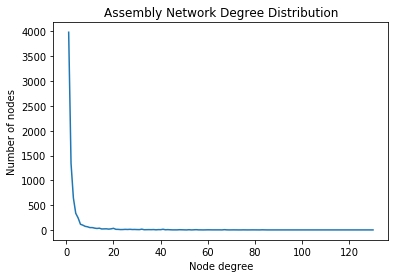

In [16]:
#
degs = {}
for n in G.nodes():
    deg = G.degree(n)
    if deg not in degs:
        degs[deg] = 0
    degs[deg] += 1
    
# Gera distribuição de graus do grafo
items = sorted(degs.items())
X = np.array([k for (k, v) in items])
Y = np.array([v for (k, v) in items])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X, Y)
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')

# Plota gráfico normal
plt.title("Assembly Network Degree Distribution")
fig.savefig("plots/AS_degree_distribution.png")

A distribuição de graus dessa rede pode dizer que...

Fazendo o gráfico log-log...

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Sigma 0.10132695977821299
Alpha 1.6566737520806012


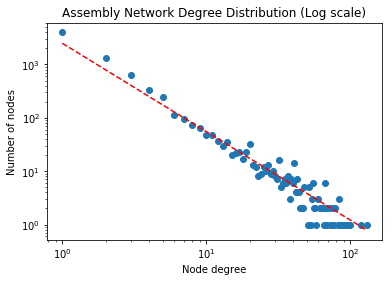

In [17]:
# Descobre coeficiente alpha da distribuição power-law -> p(k) = Ck^(-alpha)
max_degree = max(degs.keys(), key=int)
num_nodes = [] # Lista com o numero 

for i in range(1, max_degree + 1):
    num_nodes.append(degs.get(i, 0))

np.seterr(divide='ignore', invalid='ignore') # para não dar erro de divisão
fit = powerlaw.Fit(num_nodes, discrete=True)
sigma = fit.power_law.sigma
alpha = fit.power_law.alpha

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')

#pl = lambda x: 300000*(x**(-alpha)) # JavaScript
#pl = lambda x: 300000*(x**(-alpha)) # Python
#pl = lambda x: 16000*(x**(-alpha)) # Perl
pl = lambda x: 2500*(x**(-alpha)) # Assembly
#pl = lambda x: 1800*(x**(-alpha)) # Pascal
#pl = lambda x: 1000*(x**(-alpha)) # Visual Basic

ax.plot(X, Y, 'o')
ax.plot(X, pl(X), 'r--')

print("Sigma", sigma)
print("Alpha", alpha)

# Plota grafico log-log
plt.title("Assembly Network Degree Distribution (Log scale)")
fig.savefig("plots/AS_degree_distribution_loglog.png")

A rede é uma powerlaw blablabla...

### Sampling da rede

Vamos fazer uma poda da rede por causa de X Y e Z

$p(k) = Ck^{-\alpha}$

In [ ]:
#https://github.com/Ashish7129/Graph-Sampling

In [23]:
class MHRW():
    def __init__(self):
        self.G1 = nx.Graph()
        
    def mhrw(self,G,node,size):
        dictt = {}
        node_list = set()
        node_list.add(node)
        parent_node = node_list.pop()
        dictt[parent_node] = parent_node
        degree_p = G.degree(parent_node)
        related_list = list(G.neighbors(parent_node))
        node_list.update(related_list)

        while(len(self.G1.nodes()) < size):
            if(len(node_list) > 0):
                child_node = node_list.pop()
                p =  round(random.uniform(0,1),4)
                if(child_node not in dictt):
                    related_listt = list(G.neighbors(child_node))
                    degree_c = G.degree(child_node)
                    dictt[child_node] = child_node
                    if(p <= min(1,degree_p/degree_c) and child_node in list(G.neighbors(parent_node))):
                        self.G1.add_edge(parent_node,child_node)
                        parent_node = child_node
                        degree_p = degree_c
                        node_list.clear()
                        node_list.update(related_listt)
                    else:
                        del dictt[child_node]


            # node_list set becomes empty or size is not reached 
            # insert some random nodes into the set for next processing
            else:
                node_list.update(random.sample(set(G.nodes())-set(self.G1.nodes()),3))
                parent_node = node_list.pop()
                G.add_node(parent_node)
                related_list = list(G.neighbors(parent_node))
                node_list.clear()
                node_list.update(related_list)
        return self.G1

In [42]:
import random

G = nx.read_edgelist('data/RB_topological_network.csv', delimiter=',')

nodes = nx.number_of_nodes(G)
size = int(nodes / 2)
#random_node = list(G.nodes())[0]
random_node = random.choice(list(G.nodes))
print(random_node)

sample = MHRW()
sample.mhrw(G, random_node, size)

#network_statistics(G)
network_statistics(sample.G1)

nx.write_edgelist(sample.G1, "data/AS_sample_network.csv", delimiter=",", data=False)



3124834
Nodes: 3759
Edges: 2633
Density: 0.0003727792697915282
